In [1]:
# dependencies. 
## colab version (Uncomment the below line)

#!pip install tweet-preprocessor

##Jupyter notebook version

import sys
!{sys.executable} -m pip install tweet-preprocessor 

In [2]:
import pandas as pd
import numpy as np
import re, os, csv
import itertools, pickle
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, TweetTokenizer
from collections import Counter
from tensorflow.keras.preprocessing import text
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras import backend as K
import nltk
import statistics
import preprocessor as p
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [3]:
# Loading the data.
raw_data = pd.read_csv('tweet_data.csv', names=["content", "sentiment"])
raw_data = raw_data.dropna()
cleaned_data = raw_data.reset_index(drop = True)
print(cleaned_data.head())

                                             content  sentiment
0  do not get angry or frustrated or desperate or...          4
1  sickening i hurt for florida later for the wha...          4
2  this rainfall is a savage y fall when am in d ...          4
3  angry guy screws his gf in very rude manner po...          4
4  silence is better when you re angry and frustr...          4


In [31]:
elements = Counter(cleaned_data["sentiment"])
print(elements)
most_freq_emotion = elements.most_common()[0][0]
print(f"apparition of the most freq emotion ({most_freq_emotion}) : {elements[most_freq_emotion]} times")

Counter({1: 16293, 2: 15931, 0: 9573, 3: 4300, 4: 1109})
apparition of the most freq emotion (1) : 16293 times


In [4]:
# changing the labels into one hot vectors for training. 
y_data = to_categorical(cleaned_data['sentiment'])

In [5]:
#cleaning the data. 
cleaned_data['content'] = cleaned_data['content'].map(p.clean)
cleaned_data.head()

,content,sentiment
0,do not get angry or frustrated or desperate or...,4
1,sickening i hurt for florida later for the wha...,4
2,this rainfall is a savage y fall when am in d ...,4
3,angry guy screws his gf in very rude manner po...,4
4,silence is better when you re angry and frustr...,4


In [6]:
## Code to preprocess tweet data.

def preprocess_data(data):
    #Removes Numbers
    data = data.astype(str).str.replace('\d+', '')
    lower_text = data.str.lower()
    lemmatizer = nltk.stem.WordNetLemmatizer()
    w_tokenizer =  TweetTokenizer()

    def lemmatize_text(text):
        return [(lemmatizer.lemmatize(w)) for w \
                        in w_tokenizer.tokenize((text))]
    def remove_punctuation(words):
        new_words = []
        for word in words:
            new_word = re.sub(r'[^\w\s]', '', (word))
            if new_word != '':
                new_words.append(new_word)
        return new_words
    words = lower_text.apply(lemmatize_text)
    words = words.apply(remove_punctuation)
    return pd.DataFrame(words)

In [7]:
cleaned_data[['content']]

,content
0,do not get angry or frustrated or desperate or...
1,sickening i hurt for florida later for the wha...
2,this rainfall is a savage y fall when am in d ...
3,angry guy screws his gf in very rude manner po...
4,silence is better when you re angry and frustr...
...,...
47201,okla man learns fate for hate crime slaying of...
47202,i am positive that i want to stay uplifted des...
47203,okla man sentenced for hate crime slaying of l...
47204,just opened this on a train i really hate twit...


In [8]:
pre_tweets = preprocess_data(cleaned_data['content'])
pre_tweets.head()

,content
0,"[do, not, get, angry, or, frustrated, or, desp..."
1,"[sickening, i, hurt, for, florida, later, for,..."
2,"[this, rainfall, is, a, savage, y, fall, when,..."
3,"[angry, guy, screw, his, gf, in, very, rude, m..."
4,"[silence, is, better, when, you, re, angry, an..."


In [9]:
## code for removing stop words. 
stop_words = set(stopwords.words('english'))
pre_tweets['content'] = pre_tweets['content'].apply(lambda x: [item for item in \
                                    x if item not in stop_words])

pre_tweets.head()

,content
0,"[get, angry, frustrated, desperate, enraged, d..."
1,"[sickening, hurt, florida, later, know, feel, ..."
2,"[rainfall, savage, fall, club, n, home, hot, l..."
3,"[angry, guy, screw, gf, rude, manner, portsmouth]"
4,"[silence, better, angry, frustrated, reacting,..."


In [10]:
# sentence length data for statistics. 
word_count_list = []
for sentence in pre_tweets['content']:
    word_count_list.append(len(sentence))


In [11]:
# Tokenising the tweet data.
word_tokenizer = text.Tokenizer()
word_tokenizer.fit_on_texts(pre_tweets['content'])

In [12]:
vocab_length = len(word_tokenizer.word_index) + 1
embedded_sentences = word_tokenizer.texts_to_sequences(pre_tweets['content'])

In [14]:
# stats to decide on the optimal length of the sentence.
median_length = statistics.median(word_count_list)
print(median_length)
mean_length = statistics.mean(word_count_list)
print(mean_length)
st_dev = statistics.stdev(word_count_list)
print(st_dev)

7.0
7.578549336948693
3.990504137584777


In [15]:
# set the sentence length here based on the above stats. 
SENTENCE_LENGTH = 15
padded_sentences = pad_sequences(embedded_sentences, SENTENCE_LENGTH, padding='post')


In [16]:
# loading standard Glove vectors
embeddings_dictionary = dict()
glove_file = open('glove.twitter.27B.50d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = np.asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions

glove_file.close()

In [17]:
# Embedding the words
embedding_matrix = np.zeros((vocab_length, 50))
for word, index in word_tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [18]:
# Test - Train split. 
X_train, X_test, y_train, y_test = train_test_split(padded_sentences, y_data, test_size = 0.2)

In [19]:
# Attention layer Implementation. 

class attention(Layer):
    
    def __init__(self, return_sequences=True):
        self.return_sequences = return_sequences
        super(attention,self).__init__()
        
    def build(self, input_shape):
        
        self.W=self.add_weight(name="att_weight", shape=(input_shape[-1],1),
                               initializer="normal")
        self.b=self.add_weight(name="att_bias", shape=(input_shape[1],1),
                               initializer="zeros")
        
        super(attention,self).build(input_shape)
        
    def call(self, x):
        
        e = K.tanh(K.dot(x,self.W)+self.b)
        a = K.softmax(e, axis=1)
        output = x*a
        
        if self.return_sequences:
            return output
        
        return K.sum(output, axis=1)


In [33]:
from keras.backend import clear_session
# Define the model for learning (Attention - Bidirectional LTSM)

clear_session()
model = Sequential()
model.add(layers.Embedding(vocab_length, 
                           50,
                           weights=[embedding_matrix],
                           input_length=SENTENCE_LENGTH, 
                           trainable=False))
model.add(layers.Dropout(0.3))
model.add(layers.Bidirectional(
    layers.LSTM(64, dropout=0.3, 
                kernel_regularizer=tf.keras.regularizers.l2(1e-5), 
                return_sequences=True)))
model.add(attention(return_sequences=False))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(5, activation = 'softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 15, 50)            1509000   
_________________________________________________________________
dropout (Dropout)            (None, 15, 50)            0         
_________________________________________________________________
bidirectional (Bidirectional (None, 15, 128)           58880     
_________________________________________________________________
attention (attention)        (None, 128)               143       
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 5)                 645       
Total params: 1,568,668
Trainable params: 59,668
Non-trainable params: 1,509,000
_________________________________________

In [34]:

## earlystoping
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy', 
    verbose=1,
    patience=30,
    mode='max',
    restore_best_weights=True)

# Model optimiser and training code.
opt = tf.keras.optimizers.Adadelta(learning_rate=1.0)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
history = model.fit(X_train, y_train,
                    batch_size=32,
                    epochs=250,
                    verbose=1,
                    use_multiprocessing=True,  
                    #callbacks=[early_stopping],                   
                    validation_data=(X_test, y_test))

Epoch 1/250
1181/1181 [==============================] - 19s 13ms/step - loss: 1.2227 - accuracy: 0.4699 - val_loss: 1.0264 - val_accuracy: 0.5697
Epoch 2/250
1181/1181 [==============================] - 15s 13ms/step - loss: 1.0727 - accuracy: 0.5409 - val_loss: 1.0259 - val_accuracy: 0.5676
Epoch 3/250
1181/1181 [==============================] - 15s 13ms/step - loss: 1.0332 - accuracy: 0.5639 - val_loss: 0.9804 - val_accuracy: 0.5878
Epoch 4/250
1181/1181 [==============================] - 15s 13ms/step - loss: 1.0305 - accuracy: 0.5626 - val_loss: 0.9671 - val_accuracy: 0.5934
Epoch 5/250
1181/1181 [==============================] - 15s 13ms/step - loss: 1.0191 - accuracy: 0.5697 - val_loss: 0.9552 - val_accuracy: 0.5984
Epoch 6/250
1181/1181 [==============================] - 15s 13ms/step - loss: 1.0005 - accuracy: 0.5730 - val_loss: 0.9594 - val_accuracy: 0.5976
Epoch 7/250
1181/1181 [==============================] - 15s 13ms/step - loss: 1.0001 - accuracy: 0.5763 - val_loss: 0

In [35]:
# Create a directory for saving figures.
if not os.path.isdir('figures'):
    os.makedirs('figures')

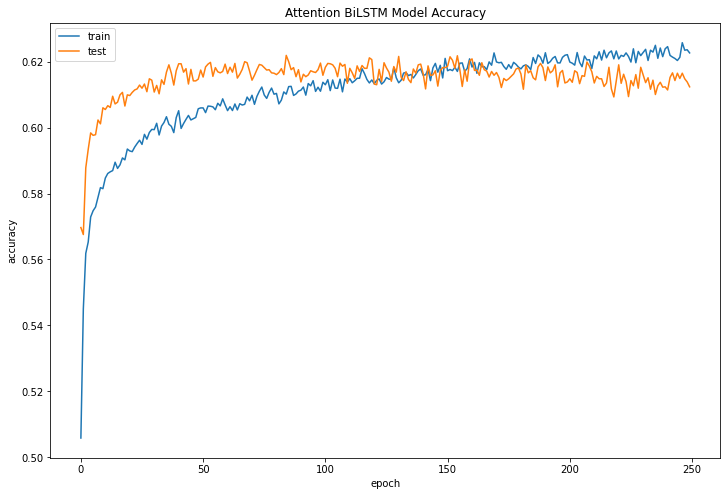

In [41]:
# Accuracy plot for the model. 

fig = plt.figure(figsize=[12,8])
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Attention BiLSTM Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.savefig('./figures/Bilstm_accuracy.png')
plt.show()

In [42]:
# Loss plot for the Model.

fig = plt.figure(figsize=[12,8]
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Attention BiLSTM Model loss')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.savefig('./figures/Bilstm_loss.png')
plt.show()

SyntaxError: ignored

In [38]:
# prediction on test data for prediction Metrics
y_pred = model.predict(X_test)
Y_test = np.argmax(y_test, axis=1) 
y_pred_class = np.argmax(y_pred,axis=1)

In [39]:
# Classification report for the predicted results.

classes = ["neutral", "happy", "sad", "hate","anger"]
print(classification_report(Y_test, y_pred_class, target_names=classes))

              precision    recall  f1-score   support

     neutral       0.46      0.35      0.40      1898
       happy       0.62      0.71      0.66      3252
         sad       0.60      0.65      0.62      3195
        hate       0.87      0.68      0.76       877
       anger       0.91      0.68      0.78       220

    accuracy                           0.61      9442
   macro avg       0.69      0.61      0.64      9442
weighted avg       0.61      0.61      0.61      9442



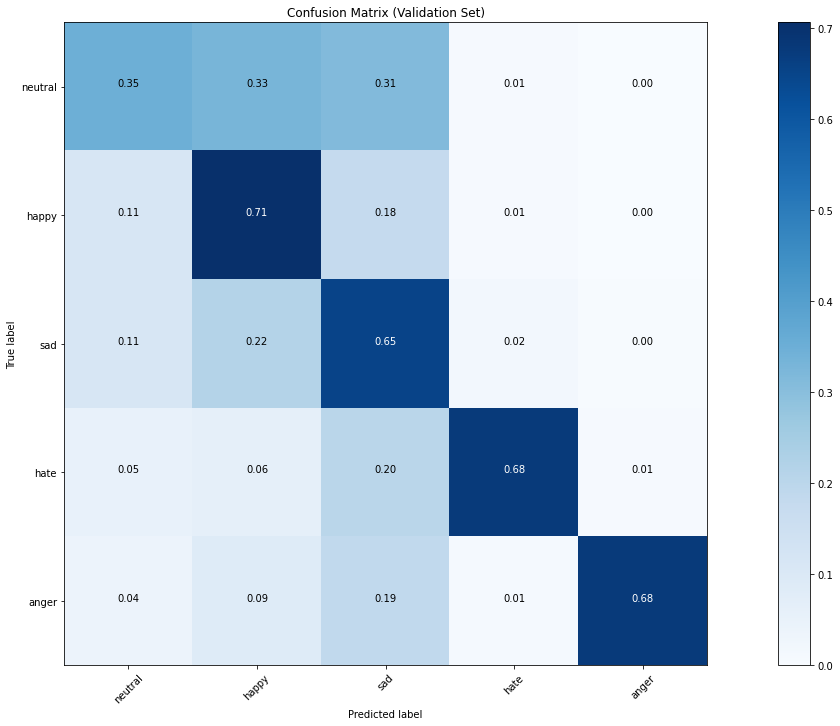

In [40]:
# Confusion matrix for results visualistaion

cnf_matrix = confusion_matrix(Y_test, y_pred_class)

def plot_confusion_matrix(cm, labels,
                          normalize=True,
                          title='Confusion Matrix (Validation Set)',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        #print('Confusion matrix, without normalization')
        pass

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig('conf_matrix.png')

plt.figure(figsize=(20,10))
plot_confusion_matrix(cnf_matrix, labels=classes)